In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import os
from glob import glob
import re
import pandas as pd

import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np

import torch.nn as nn
from torch.utils.data import DataLoader, random_split

import torch.optim as optim
import torch.nn.functional as F
from torchvision import models, transforms
import seaborn as sns
from torchvision.models.feature_extraction import create_feature_extractor, get_graph_node_names

In [4]:
def extract_number(filename):
    # Extract the number from the filename
    match = re.search(r'im(\d+)\.png', filename)
    if match:
        return int(match.group(1))
    return 0  # Return 0 if no number is found

def sort_filenames(filenames):
    # Sort the filenames based on the extracted number
    return sorted(filenames, key=extract_number)

class Coco1600SequenceDataset(Dataset):
    def __init__(self, meta_file, img_dir, num_timesteps=5, transform=None):
        self.img_labels = pd.read_csv(meta_file)
        self.img_dir = img_dir
        self.num_timesteps = num_timesteps
        self.transform = transform
        self.to_grayscale = transforms.Grayscale(3)  # 3-channel grayscale
        
        # Create index map for object labels
        self.label_to_idx = {label: idx for idx, label in enumerate(self.img_labels['obj'].unique())}
    
    def __len__(self):
        return len(self.img_labels)

    def __coco1600_to_hvm200(self, label):

        coco1600_to_hvm200 = {
            "bear": "bear",
            "ELEPHANT_M": "elephant",
            "face0001": "person",
            "alfa155": "car",
            "breed_pug": "dog",
            "Apple_Fruit_obj": "apple",
            "_001": "chair",
            "f16": "plane",
            "lo_poly_animal_CHICKDEE": "bird",
            "zebra": "zebra"
        }
        
        return coco1600_to_hvm200[label]
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        img_name = self.img_labels.iloc[idx]['image_names']
        img_path = os.path.join(self.img_dir, img_name)
        image = Image.open(img_path).convert('RGB')
        
        label = self.img_labels.iloc[idx]['obj']
        label_idx = self.label_to_idx[label]
        
        # Create sequence: first frame is the original image, rest are grayscale
        sequence = [self.transform(image) if self.transform else transforms.ToTensor()(image) for _ in range(3)]
        for _ in range(self.num_timesteps - 1):
            # gray_value = torch.rand(1).item()
            gray_value = 0.5
            
            gray_frame = torch.full((3, 224, 224), gray_value)  # Assuming 224x224 is your image size
            sequence.append(gray_frame)
        
        sequence = torch.stack(sequence)
        return sequence, label_idx

class HVM200SequenceDataset(Dataset):
    def __init__(self, image_path, num_timesteps=5, transform=None):
        self.image_path = image_path
        self.num_timesteps = num_timesteps
        self.transform = transform or transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor()
        ])
        
        # Sort image files
        self.images = sort_filenames(glob(os.path.join(image_path, "*.png")))
        
        # Load metadata
        meta_data_path = os.path.join(image_path, "working_memory_images_labels.csv")
        self.meta_data = pd.read_csv(meta_data_path)
        self.meta_data["img_path"] = self.images
        
        # Create a mapping of unique objects to integer labels
        self.label_to_idx = {obj: i for i, obj in enumerate(self.meta_data["object"].unique())}
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        img_path = self.images[idx]
        image = Image.open(img_path).convert('RGB')
        
        # Create sequence: first frame is the original image, rest are grayscale
        sequence = [self.transform(image) for _ in range(3)]
        for _ in range(self.num_timesteps - 1):
            gray_value = 0.5
            gray_frame = torch.full((3, 224, 224), gray_value)
            sequence.append(gray_frame)
        
        sequence = torch.stack(sequence)
        
        label = self.meta_data.loc[self.meta_data["img_path"] == img_path, "object"].values[0]
        label_idx = self.label_to_idx[label]
        
        return sequence, label_idx
    
    def hvm200_to_coco1600(self, label):
        hvm200_to_coco1600 = {
            "bear": "bear",
            "elephant": "ELEPHANT_M",
            "person": "face0001",
            "car": "alfa155",
            "dog": "breed_pug",
            "apple": "Apple_Fruit_obj",
            "chair": "_001",
            "plane": "f16",
            "bird": "lo_poly_animal_CHICKDEE",
            "zebra": "zebra"
        }
        return hvm200_to_coco1600.get(label, label)

def plot_sequence_samples(dataset, num_samples=5):
    fig, axes = plt.subplots(num_samples, dataset.num_timesteps + 3 - 1, figsize=(15, 3*num_samples))
    
    for i in range(num_samples):
        sequence, label = dataset[np.random.randint(len(dataset))]
        for t in range(dataset.num_timesteps + 3 - 1):
            ax = axes[i, t]
            ax.imshow(sequence[t].permute(1, 2, 0))
            ax.axis('off')
            if t == 0:
                ax.set_title(f"Label: {list(dataset.label_to_idx.keys())[list(dataset.label_to_idx.values()).index(label)]}")
    
    plt.tight_layout()
    plt.show()

import torch
import torch.nn as nn
from torchvision import models

class ResNetLSTM(nn.Module):
    def __init__(self, num_classes, hidden_size=256, num_layers=1, dropout_rate=0.5):
        super(ResNetLSTM, self).__init__()
        
        # Load ResNet50 architecture (without weights)
        # self.resnet = models.resnet50(weights=None)
        self.resnet = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
        
        num_ftrs = self.resnet.fc.in_features
        self.resnet.fc = nn.Linear(num_ftrs, num_classes)
        
        # Load your fine-tuned weights
        # self.resnet.load_state_dict(torch.load('version1_analysis/resnet50_finetuned_coco1400.pth'))
        
        # Remove the final fully connected layer
        self.resnet = nn.Sequential(*list(self.resnet.children())[:-1])
        
        # Freeze ResNet50 layers
        for param in self.resnet.parameters():
            param.requires_grad = False
        
        # Get the number of features from the last layer of ResNet50
        self.resnet_out_features = 2048  # This is the number of features output by ResNet50

        self.dropout = nn.Dropout(dropout_rate)
        
        # LSTM layer
        self.lstm = nn.LSTM(input_size=self.resnet_out_features, 
                            hidden_size=hidden_size, 
                            num_layers=num_layers, 
                            batch_first=True)
        
        # Combine features
        self.combine_features = nn.Sequential(
            nn.Linear(self.resnet_out_features + hidden_size, 512),
            nn.ReLU(),
            nn.Dropout(0.5)
        )
        
        # Final classifier
        self.classifier = nn.Linear(512, num_classes)

    def forward(self, x):
        batch_size, timesteps, C, H, W = x.size()
        c_in = x.view(batch_size * timesteps, C, H, W)
        
        # Extract features using ResNet50
        resnet_features = self.resnet(c_in)
        resnet_features = resnet_features.view(batch_size, timesteps, -1)

        # Apply dropout to ResNet features
        resnet_features = self.dropout(resnet_features)
        
        # Pass through LSTM
        lstm_out, (h_n, c_n) = self.lstm(resnet_features)
        # Apply dropout to LSTM output
        lstm_out = self.dropout(lstm_out)
        
        # Get the last output of LSTM
        lstm_last_out = lstm_out[:, -1, :]
        
        # Get the last ResNet features
        resnet_last_out = resnet_features[:, -1, :]
        
        # Combine LSTM and ResNet features
        combined = torch.cat((resnet_last_out, lstm_last_out), dim=1)
        # Apply dropout to combined features
        combined = self.dropout(combined)
        
        combined_features = self.combine_features(combined)
        # Apply dropout before final classification
        combined_features = self.dropout(combined_features)
        
        # Final classification
        output = self.classifier(combined_features)
        
        return output

Dataset size: 200
Number of classes: 10
Classes: {'bear': 0, 'elephant': 1, 'person': 2, 'car': 3, 'dog': 4, 'apple': 5, 'chair': 6, 'plane': 7, 'bird': 8, 'zebra': 9}


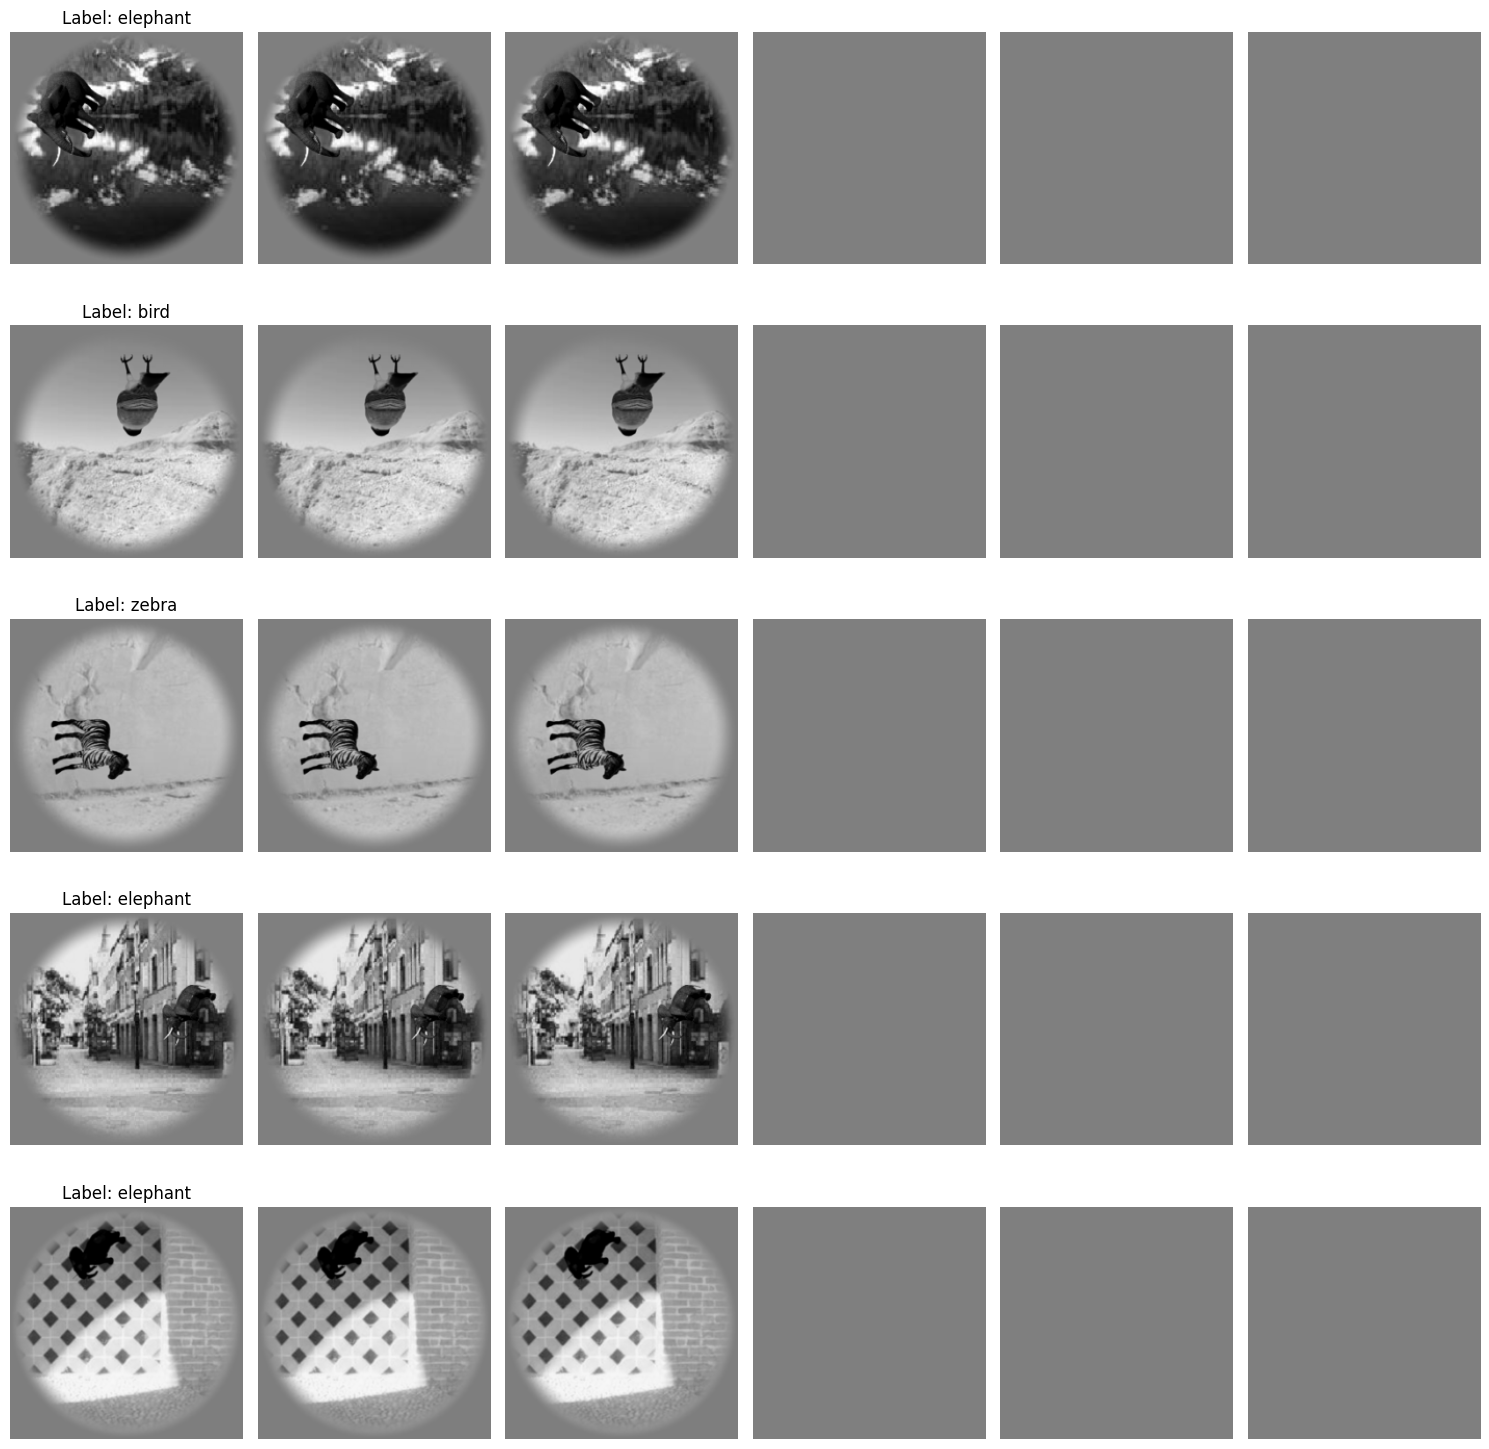

In [5]:
# Usage example:
image_path = "data/hvm200/"

num_timesteps = 4  # 100ms
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Grayscale(3),
    transforms.Normalize(mean=[0, 0, 0], std=[1, 1, 1]),
])

dataset = HVM200SequenceDataset(image_path, num_timesteps=num_timesteps, transform=transform)
# Create the dataset
# dataset = Coco1600SequenceDataset(meta_file='data/split_dataset/train_coco1600/coco1400_meta.csv',
#                              img_dir='data/split_dataset/train_coco1600/images_cocogray',
#                              num_timesteps=num_timesteps,
#                              transform=transform)

print(f"Dataset size: {len(dataset)}")
print(f"Number of classes: {len(dataset.label_to_idx)}")
print(f"Classes: {dataset.label_to_idx}")

plot_sequence_samples(dataset)

batch_size = 32
loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

for image, label in loader:
    pass

In [6]:
# Usage example:
num_classes = 10  # Adjust based on your dataset
model = ResNetLSTM(num_classes)

# If you want to use GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Print model summary
print(model)

# Example input
batch_size = 4
timesteps = 5
channels = 3
height = 224
width = 224
example_input = torch.randn(batch_size, timesteps, channels, height, width).to(device)
output = model(example_input)
print(f"Output shape: {output.shape}")

ResNetLSTM(
  (resnet): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv2d(64

In [7]:
train_nodes, val_nodes = get_graph_node_names(model)
val_nodes

['x',
 'size',
 'getitem',
 'getitem_1',
 'getitem_2',
 'getitem_3',
 'getitem_4',
 'mul',
 'view',
 'resnet.0',
 'resnet.1',
 'resnet.2',
 'resnet.3',
 'resnet.4.0.conv1',
 'resnet.4.0.bn1',
 'resnet.4.0.relu',
 'resnet.4.0.conv2',
 'resnet.4.0.bn2',
 'resnet.4.0.relu_1',
 'resnet.4.0.conv3',
 'resnet.4.0.bn3',
 'resnet.4.0.downsample.0',
 'resnet.4.0.downsample.1',
 'resnet.4.0.add',
 'resnet.4.0.relu_2',
 'resnet.4.1.conv1',
 'resnet.4.1.bn1',
 'resnet.4.1.relu',
 'resnet.4.1.conv2',
 'resnet.4.1.bn2',
 'resnet.4.1.relu_1',
 'resnet.4.1.conv3',
 'resnet.4.1.bn3',
 'resnet.4.1.add',
 'resnet.4.1.relu_2',
 'resnet.4.2.conv1',
 'resnet.4.2.bn1',
 'resnet.4.2.relu',
 'resnet.4.2.conv2',
 'resnet.4.2.bn2',
 'resnet.4.2.relu_1',
 'resnet.4.2.conv3',
 'resnet.4.2.bn3',
 'resnet.4.2.add',
 'resnet.4.2.relu_2',
 'resnet.5.0.conv1',
 'resnet.5.0.bn1',
 'resnet.5.0.relu',
 'resnet.5.0.conv2',
 'resnet.5.0.bn2',
 'resnet.5.0.relu_1',
 'resnet.5.0.conv3',
 'resnet.5.0.bn3',
 'resnet.5.0.downsamp

Dataset size: 200
Number of classes: 10
Classes: {'bear': 0, 'elephant': 1, 'person': 2, 'car': 3, 'dog': 4, 'apple': 5, 'chair': 6, 'plane': 7, 'bird': 8, 'zebra': 9}


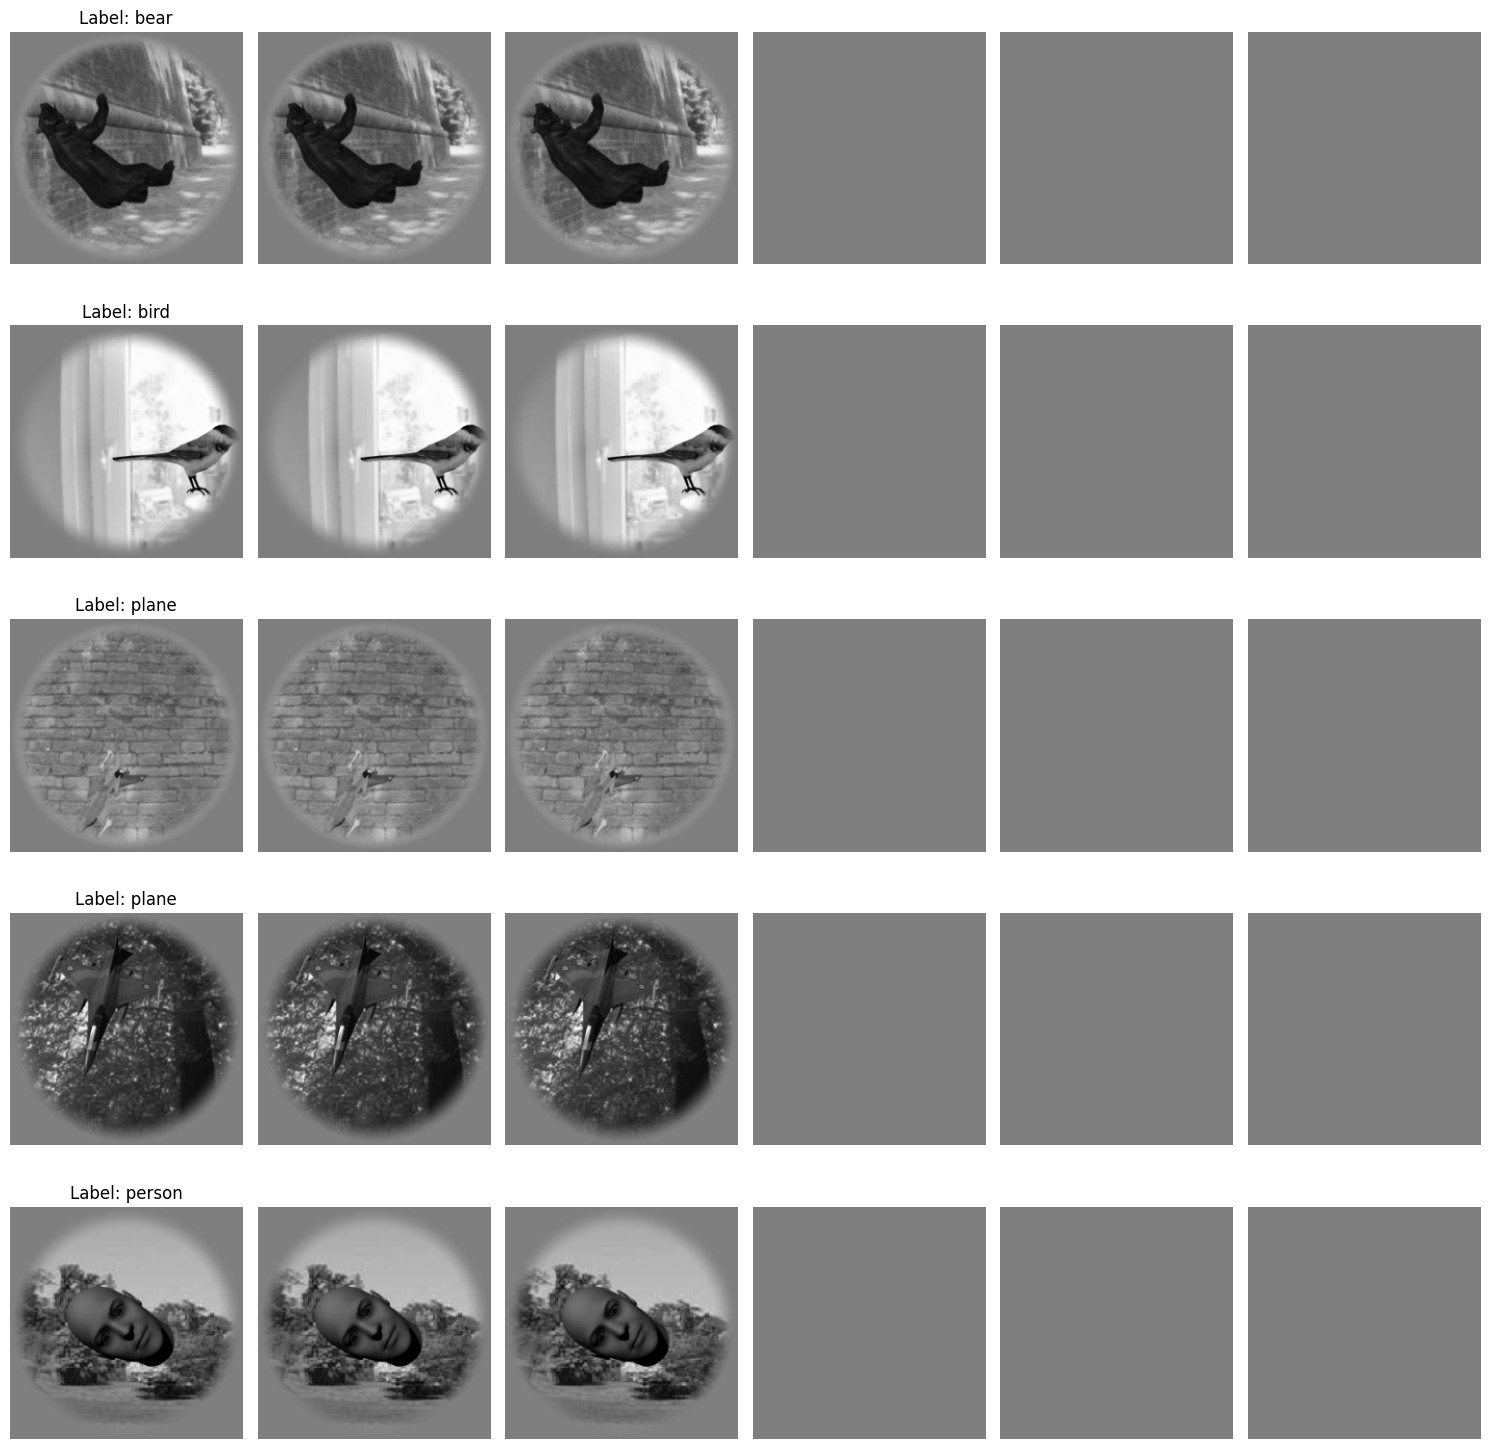

output['IT'].mean() = tensor(-439.0242, device='cuda:0', grad_fn=<MeanBackward0>)
output['IT'].std() = tensor(792.8336, device='cuda:0', grad_fn=<StdBackward0>)
output['IT'].min() = tensor(-3173.2532, device='cuda:0', grad_fn=<MinBackward1>)
output['IT'].max() = tensor(1988.4531, device='cuda:0', grad_fn=<MaxBackward1>)
output['IT'].size() = torch.Size([4, 512])


In [6]:
# First define dataset
# Usage example:
image_path = "data/hvm200/"

num_timesteps = 4  # 100ms
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Grayscale(3),
    transforms.Normalize(mean=[0, 0, 0], std=[1, 1, 1]),
])

dataset = HVM200SequenceDataset(image_path, num_timesteps=num_timesteps, transform=transform)
# Create the dataset
# dataset = Coco1600SequenceDataset(meta_file='data/split_dataset/train_coco1600/coco1400_meta.csv',
#                              img_dir='data/split_dataset/train_coco1600/images_cocogray',
#                              num_timesteps=num_timesteps,
#                              transform=transform)

print(f"Dataset size: {len(dataset)}")
print(f"Number of classes: {len(dataset.label_to_idx)}")
print(f"Classes: {dataset.label_to_idx}")

plot_sequence_samples(dataset)

batch_size = 32
loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

for image, label in loader:
    pass

# Usage example:
num_classes = 10  # Adjust based on your dataset
model = ResNetLSTM(num_classes)
model.load_state_dict(torch.load("version_3_use_resnet_pytorch/resnetPytorch_lstm_finetuned_100ms_delay_coco1400_100ms_object_best.pth"))

# If you want to use GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
model.eval()

model = create_feature_extractor(model, return_nodes={"combine_features.0": "IT"})
# model = create_feature_extractor(model, return_nodes=["combine_features.0"])


# Example input
batch_size = 4
timesteps = 10
channels = 3
height = 224
width = 224
example_input = torch.randn(batch_size, timesteps, channels, height, width).to(device)
output = model(example_input)

print(f"{output['IT'].mean() = }")
print(f"{output['IT'].std() = }")
print(f"{output['IT'].min() = }")
print(f"{output['IT'].max() = }")
print(f"{output['IT'].size() = }")


Training with 20.0% of data


100%|██████████| 5/5 [00:01<00:00,  3.99it/s]


X_train.shape = (40, 512)
X_val.shape = (160, 512)


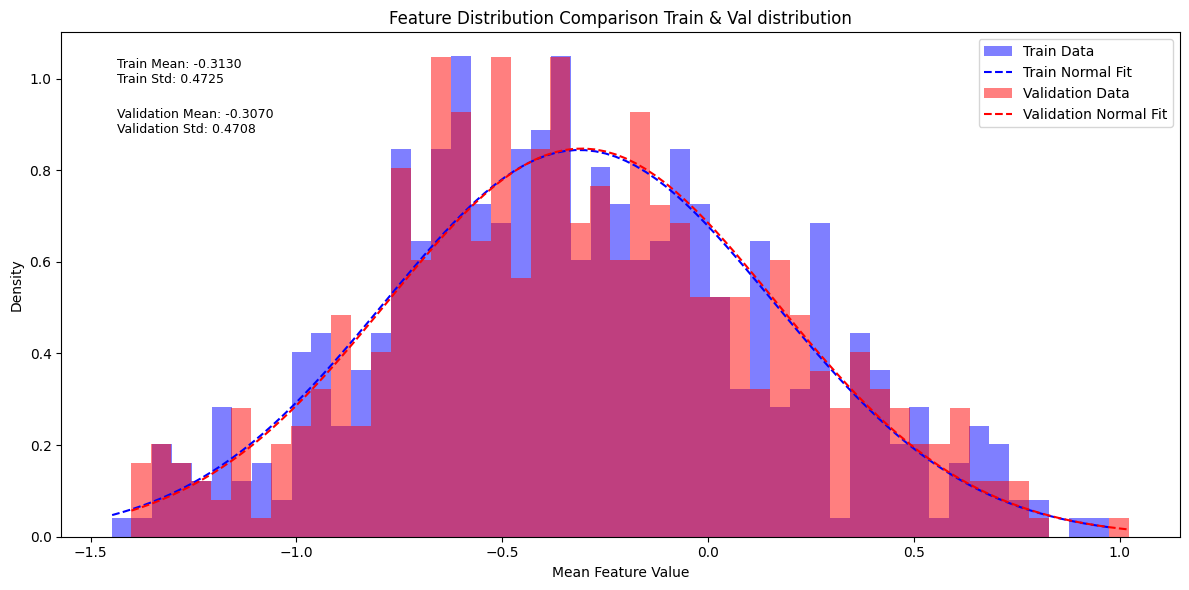

Results saved to 'hvm200_resnetlstm_logistic_minmax_scaled_20percent.csv'
Validation Accuracy: 32.50%

Statistics:
count    1.600000e+02
mean     2.994363e+01
std      3.776793e+01
min      5.401261e-10
25%      1.873176e-01
50%      2.958173e+00
75%      6.387549e+01
max      9.999736e+01
Name: i1, dtype: float64

Top 5 highest i1 values:
     image_index true_label predicted_label         i1
3              3      zebra           zebra  99.997363
27            27      zebra           zebra  99.996056
148          148      zebra           zebra  99.993656
126          126      zebra           zebra  99.886674
52            52      zebra           zebra  99.833461

Bottom 5 lowest i1 values:
     image_index true_label predicted_label            i1
94            94        dog            bird  5.401261e-10
115          115        dog            bird  6.304005e-10
81            81        car             dog  3.183089e-07
159          159       bird           apple  5.558475e-07
155       

100%|██████████| 4/4 [00:00<00:00,  4.28it/s]


X_train.shape = (80, 512)
X_val.shape = (120, 512)


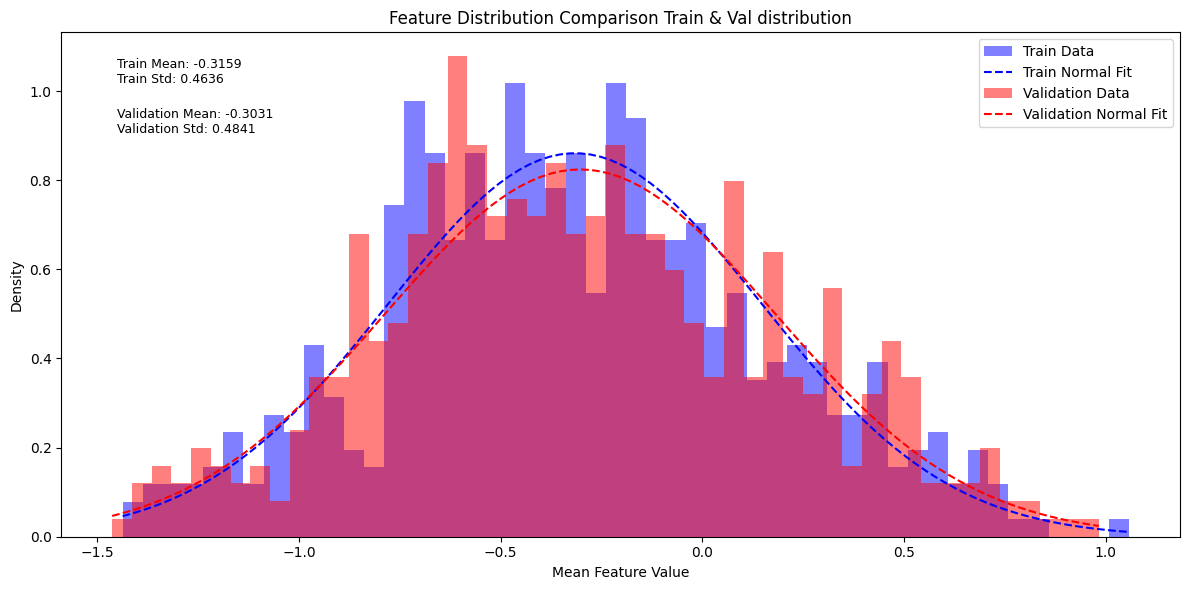

Results saved to 'hvm200_resnetlstm_logistic_minmax_scaled_40percent.csv'
Validation Accuracy: 34.17%

Statistics:
count    1.200000e+02
mean     3.015743e+01
std      3.403705e+01
min      7.499924e-12
25%      2.649216e+00
50%      1.254009e+01
75%      5.581730e+01
max      9.998629e+01
Name: i1, dtype: float64

Top 5 highest i1 values:
     image_index true_label predicted_label         i1
114          114      zebra           zebra  99.986290
29            29      zebra           zebra  99.981983
52            52      zebra           zebra  99.977504
3              3      zebra           zebra  98.499865
102          102      zebra           zebra  97.255843

Bottom 5 lowest i1 values:
    image_index true_label predicted_label            i1
20           20        car             dog  7.499924e-12
57           57     person            bird  5.027525e-05
65           65   elephant            bear  1.439529e-04
33           33        dog            bear  2.226919e-03
59           59

100%|██████████| 4/4 [00:00<00:00,  5.24it/s]


X_train.shape = (100, 512)
X_val.shape = (100, 512)


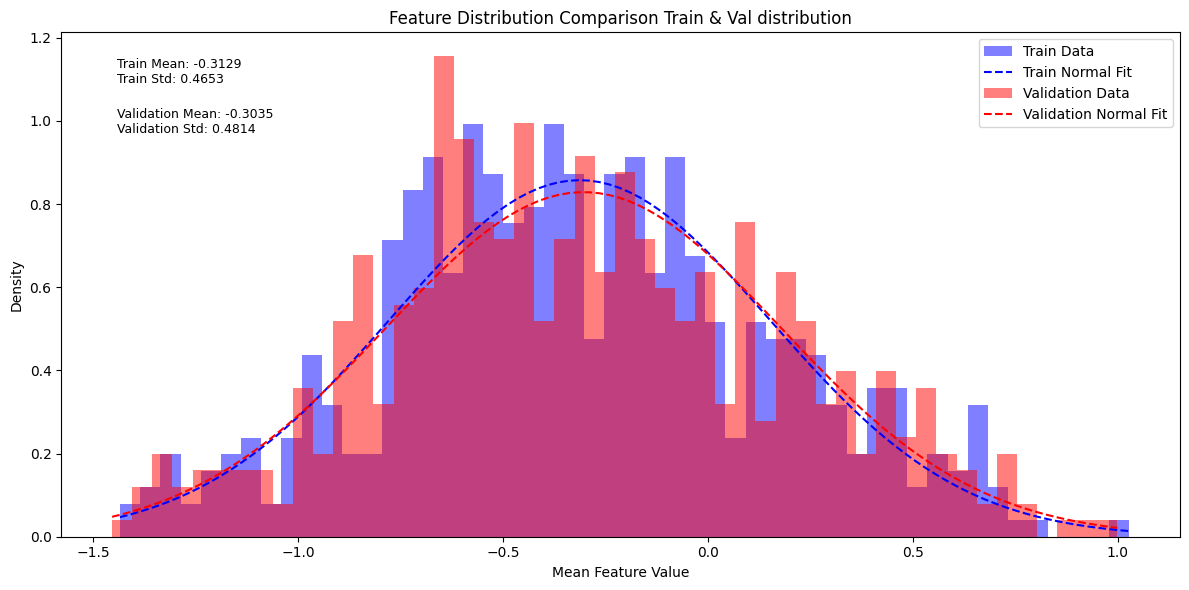

Results saved to 'hvm200_resnetlstm_logistic_minmax_scaled_50percent.csv'
Validation Accuracy: 32.00%

Statistics:
count    1.000000e+02
mean     2.877962e+01
std      3.429219e+01
min      6.809746e-07
25%      2.310799e+00
50%      1.087797e+01
75%      5.731750e+01
max      9.998141e+01
Name: i1, dtype: float64

Top 5 highest i1 values:
    image_index true_label predicted_label         i1
62           62      zebra           zebra  99.981408
94           94      zebra           zebra  99.975079
4             4      zebra           zebra  98.943801
56           56       bear            bear  98.361807
29           29      zebra           zebra  97.278775

Bottom 5 lowest i1 values:
    image_index true_label predicted_label            i1
89           89        car             dog  6.809746e-07
81           81     person            bird  2.086926e-05
93           93   elephant            bear  2.596573e-04
92           92       bird             dog  9.416576e-03
40           40     p

100%|██████████| 3/3 [00:00<00:00,  4.90it/s]


X_train.shape = (120, 512)
X_val.shape = (80, 512)


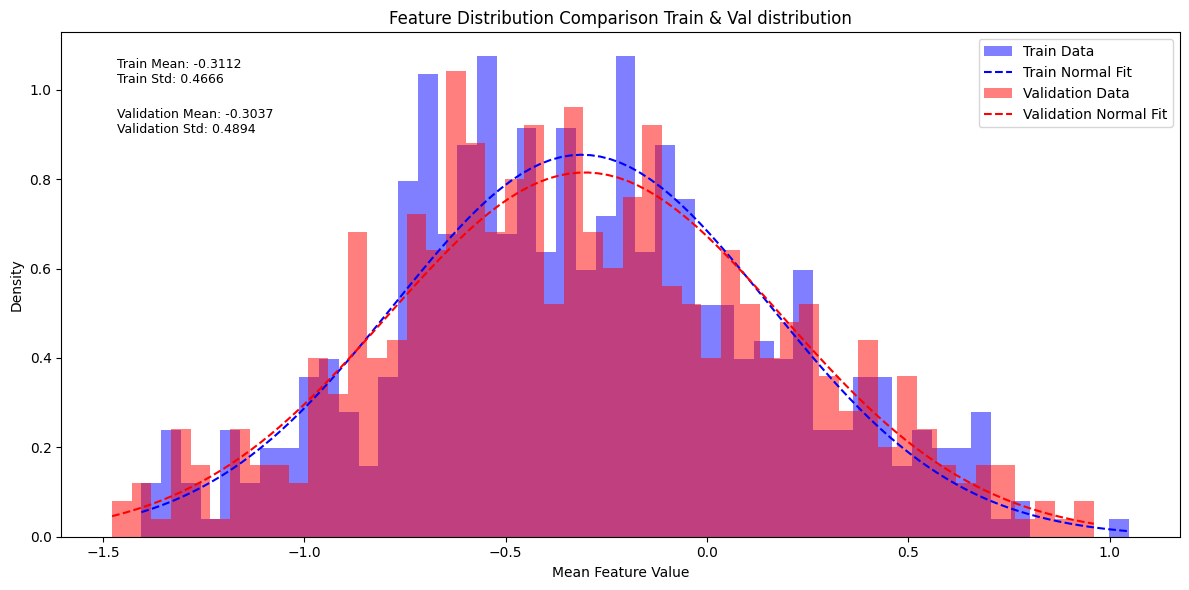

Results saved to 'hvm200_resnetlstm_logistic_minmax_scaled_60percent.csv'
Validation Accuracy: 31.25%

Statistics:
count    80.000000
mean     27.833069
std      33.141238
min       0.000003
25%       3.702063
50%      13.120804
75%      32.750443
max      99.998350
Name: i1, dtype: float64

Top 5 highest i1 values:
    image_index true_label predicted_label         i1
58           58      zebra           zebra  99.998350
42           42      zebra           zebra  99.998013
30           30       bear            bear  99.404797
60           60      zebra           zebra  99.178357
43           43       bear            bear  97.942951

Bottom 5 lowest i1 values:
    image_index true_label predicted_label        i1
63           63        car             dog  0.000003
22           22   elephant            bear  0.002477
64           64      zebra             car  0.024272
3             3      chair           zebra  0.133788
12           12   elephant          person  0.147455

Training wi

100%|██████████| 2/2 [00:00<00:00,  6.55it/s]


X_train.shape = (160, 512)
X_val.shape = (40, 512)


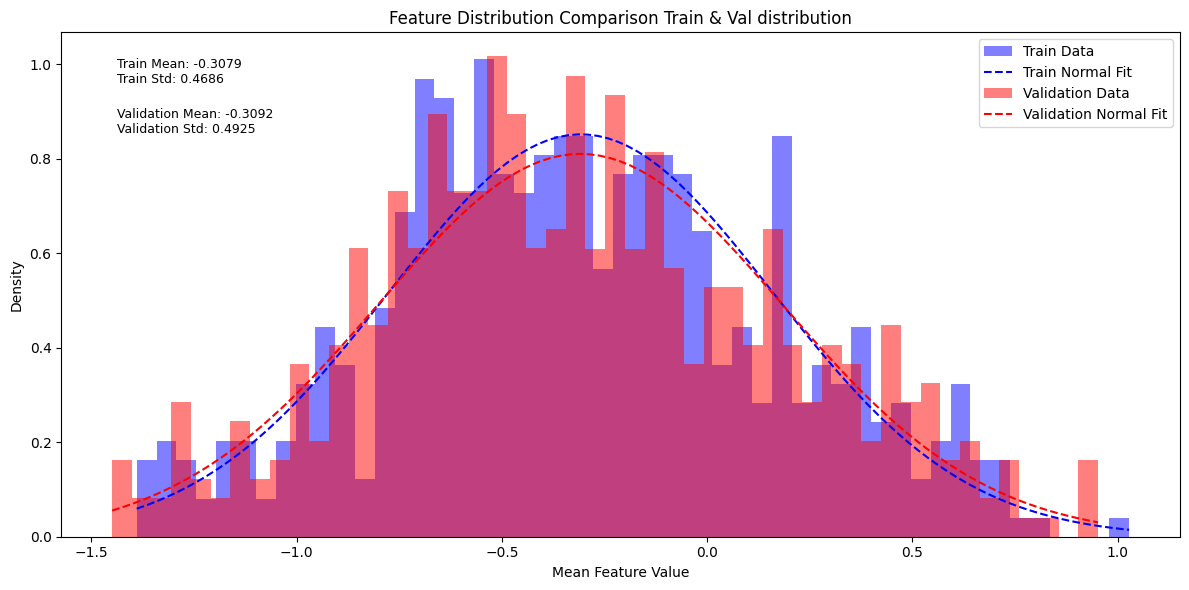

Results saved to 'hvm200_resnetlstm_logistic_minmax_scaled_80percent.csv'
Validation Accuracy: 32.50%

Statistics:
count    40.000000
mean     26.742849
std      29.767268
min       0.030950
25%       6.999613
50%      12.422667
75%      34.674904
max      99.627869
Name: i1, dtype: float64

Top 5 highest i1 values:
    image_index true_label predicted_label         i1
5             5      zebra           zebra  99.627869
33           33       bear            bear  91.851397
16           16      zebra           zebra  91.160574
35           35      apple           apple  89.865585
2             2      apple           apple  87.889005

Bottom 5 lowest i1 values:
    image_index true_label predicted_label        i1
20           20      zebra             car  0.030950
4             4   elephant            bear  0.498195
7             7       bird          person  0.770453
37           37      apple            bird  1.508689
19           19      zebra             dog  1.552436

Best model 

In [7]:
### import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Subset
from torchvision import transforms
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from tqdm import tqdm
import joblib


def extract_features(model, loader, device):
    features = []
    labels = []
    model.eval()
    with torch.no_grad():
        for images, batch_labels in tqdm(loader):
            images = images.to(device)
            output = model(images)
            features.append(output['IT'].cpu().numpy())
            labels.append(batch_labels.numpy())
    return np.vstack(features), np.concatenate(labels)

def plot_feature_distributions(X_train, X_val, title_suffix=""):
    plt.figure(figsize=(12, 6))
    
    for X, label, color in [(X_train, 'Train', 'blue'), (X_val, 'Validation', 'red')]:
        mean = np.mean(X, axis=0)
        std = np.std(X, axis=0)
        
        # Plot histogram of mean feature values
        plt.hist(mean, bins=50, density=True, alpha=0.5, color=color, label=f'{label} Data')
        
        # Fit normal distribution
        mu, sigma = stats.norm.fit(mean)
        x = np.linspace(min(mean), max(mean), 100)
        best_fit_line = stats.norm.pdf(x, mu, sigma)
        plt.plot(x, best_fit_line, color=color, linestyle='--', label=f'{label} Normal Fit')
        
        plt.annotate(f'{label} Mean: {np.mean(mean):.4f}\n{label} Std: {np.std(mean):.4f}', 
                     xy=(0.05, 0.95 - 0.1 * (['Train', 'Validation'].index(label))), 
                     xycoords='axes fraction', 
                     fontsize=9, 
                     ha='left', 
                     va='top')
    
    plt.title(f'Feature Distribution Comparison {title_suffix}')
    plt.xlabel('Mean Feature Value')
    plt.ylabel('Density')
    plt.legend()
    plt.tight_layout()
    plt.show()

def evaluate_model(clf, X, y, idx_to_label):
    y_pred = clf.predict(X)
    y_prob = clf.predict_proba(X)
    accuracy = accuracy_score(y, y_pred)
    
    results = []
    for i in range(len(y)):
        results.append({
            'image_index': i,
            'true_label_idx': y[i],
            'true_label': idx_to_label[y[i]],
            'predicted_label_idx': y_pred[i],
            'predicted_label': idx_to_label[y_pred[i]],
            'i1': y_prob[i, y[i]] * 100,
            **{f'{idx_to_label[j]}_prob': y_prob[i, j] * 100 for j in range(len(idx_to_label))}
        })
    
    return results, accuracy

# Main execution
if __name__ == "__main__":
    num_timesteps = 4  # 100ms
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Grayscale(3),
        transforms.Normalize(mean=[0, 0, 0], std=[1, 1, 1]),
    ])
    
    dataset = HVM200SequenceDataset(image_path, num_timesteps=num_timesteps, transform=transform)
    # Create the dataset
    # dataset = Coco1600SequenceDataset(meta_file='data/split_dataset/train_coco1600/coco1400_meta.csv',
    #                              img_dir='data/split_dataset/train_coco1600/images_cocogray',
    #                              num_timesteps=num_timesteps,
    #                              transform=transform)
    
    num_classes = len(dataset.label_to_idx)
    idx_to_label = {v: k for k, v in dataset.label_to_idx.items()}

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Load pre-trained ResNetLSTM model
    model = ResNetLSTM(num_classes)
    model.load_state_dict(torch.load("version_3_use_resnet_pytorch/resnetPytorch_lstm_finetuned_100ms_delay_coco1400_100ms_object_best.pth", map_location=device))
    model = model.to(device)
    model.eval()

    # Create feature extractor
    from torchvision.models.feature_extraction import create_feature_extractor
    model = create_feature_extractor(model, return_nodes={"combine_features.0": "IT"})

    best_accuracy = 0
    best_model = None
    best_fraction = None

    # Feature extraction and classification loop
    train_fractions = [0.2, 0.4, 0.5, 0.6, 0.8]
    for fraction in train_fractions:
        print(f"\nTraining with {fraction*100}% of data")
        
        # Split dataset while preserving label distribution
        train_indices, val_indices = train_test_split(
            range(len(dataset)),
            train_size=fraction,
            stratify=[dataset[i][1] for i in range(len(dataset))],
            random_state=42
        )
        
        train_dataset = Subset(dataset, train_indices)
        val_dataset = Subset(dataset, val_indices)
        
        train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)
        val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

        # Extract features
        X_train, y_train = extract_features(model, train_loader, device)
        X_val, y_val = extract_features(model, val_loader, device)
        print(f"{X_train.shape = }")
        print(f"{X_val.shape = }")
        
        
        # Plot feature distributions before scaling
        plot_feature_distributions(X_train, X_val, title_suffix="Train & Val distribution")

        
        # Create a pipeline with MinMaxScaler and LogisticRegression
        clf = Pipeline([
            # ('scaler', MinMaxScaler()),
            ('classifier', LogisticRegression(random_state=42, max_iter=1000))
        ])
        
        # Fit the pipeline
        clf.fit(X_train, y_train)
        
        # Transform the validation set using the fitted scaler
        if clf.named_steps.get('scaler', None):
            X_val_scaled = clf.named_steps['scaler'].transform(X_val)

        else: 
            X_val_scaled = X_val.copy()
        
        
        # Plot feature distributions after scaling
        # plot_feature_distributions(
        #     clf.named_steps['scaler'].transform(X_train),
        #     X_val_scaled,
        #     title_suffix="(After MinMax Scaling)"
        # )
        
        # Evaluate
        results, accuracy = evaluate_model(clf, X_val_scaled, y_val, idx_to_label)
        df = pd.DataFrame(results)
        df.to_csv(f'hvm200_resnetlstm_logistic_minmax_scaled_{int(fraction*100)}percent.csv', index=False)

        # Check if this is the best model so far
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_model = clf
            best_fraction = fraction

        print(f"Results saved to 'hvm200_resnetlstm_logistic_minmax_scaled_{int(fraction*100)}percent.csv'")
        print(f"Validation Accuracy: {accuracy*100:.2f}%")
        print("\nStatistics:")
        print(df['i1'].describe())
        print("\nTop 5 highest i1 values:")
        print(df.nlargest(5, 'i1')[['image_index', 'true_label', 'predicted_label', 'i1']])
        print("\nBottom 5 lowest i1 values:")
        print(df.nsmallest(5, 'i1')[['image_index', 'true_label', 'predicted_label', 'i1']])

    # After all fractions have been processed, save the best model
    print(f"\nBest model achieved {best_accuracy*100:.2f}% accuracy with {best_fraction*100}% of training data")
    joblib.dump(best_model, 'best_logistic_regression_model.joblib')
    print("Best model saved as 'best_logistic_regression_model.joblib'")


Processing delay: 100 (num_timesteps: 4)
Extracted features shape: (200, 512)
Accuracy for 100: 55.00%

Processing delay: 400 (num_timesteps: 13)
Extracted features shape: (200, 512)
Accuracy for 400: 33.50%

Processing delay: 800 (num_timesteps: 25)
Extracted features shape: (200, 512)
Accuracy for 800: 21.50%

Processing delay: 1200 (num_timesteps: 37)
Extracted features shape: (200, 512)
Accuracy for 1200: 20.00%


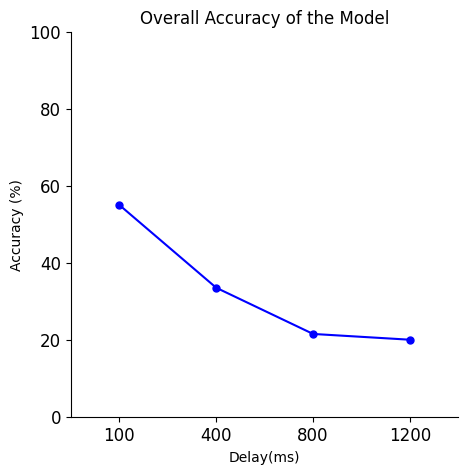

Results saved to 'accuracy_vs_delay.csv'


In [21]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import transforms
from sklearn.metrics import accuracy_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib

def extract_features(model, loader, device):
    features = []
    labels = []
    model.eval()
    with torch.no_grad():
        for images, batch_labels in loader:
            images = images.to(device)
            output = model(images)
            features.append(output['IT'].cpu().numpy())
            labels.append(batch_labels.numpy())
    return np.vstack(features), np.concatenate(labels)

def evaluate_model(clf, X, y):
    y_pred = clf.predict(X)
    accuracy = accuracy_score(y, y_pred)
    return accuracy

def main():
    image_path = "data/hvm200/"
    delay_frames = {"100": 4, "400": 13, "800": 25, "1200": 37}
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Load pre-trained ResNetLSTM model
    model = ResNetLSTM(num_classes=10)  # Adjust num_classes if needed
    model.load_state_dict(torch.load("version_3_use_resnet_pytorch/resnetPytorch_lstm_finetuned_100ms_delay_coco1400_100ms_object_best.pth", map_location=device))
    model = model.to(device)

    # Create feature extractor
    from torchvision.models.feature_extraction import create_feature_extractor
    model = create_feature_extractor(model, return_nodes={"combine_features.0": "IT"})

    # Load the saved logistic regression model
    clf = joblib.load('best_logistic_regression_model.joblib')

    accuracies = []

    for delay, num_timesteps in delay_frames.items():
        print(f"\nProcessing delay: {delay} (num_timesteps: {num_timesteps})")

        transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Grayscale(3),
            transforms.Normalize(mean=[0, 0, 0], std=[1, 1, 1]),
        ])


        dataset = HVM200SequenceDataset(image_path, num_timesteps=num_timesteps, transform=transform)
        # dataset = Coco1600SequenceDataset(meta_file='data/split_dataset/test_coco1600/coco200_meta.csv',
        #                              img_dir='data/split_dataset/test_coco1600/images_cocogray',
        #                              num_timesteps=num_timesteps,
        #                              transform=transform)

        full_loader = DataLoader(dataset, batch_size=32, shuffle=False)

        # Extract features
        X, y = extract_features(model, full_loader, device)
        print(f"Extracted features shape: {X.shape}")
        
        # If the saved model includes a scaler, apply it
        if hasattr(clf, 'named_steps') and 'scaler' in clf.named_steps:
            X_scaled = clf.named_steps['scaler'].transform(X)
        else:
            X_scaled = X

        # Evaluate
        accuracy = evaluate_model(clf, X_scaled, y)
        print(f"Accuracy for {delay}: {accuracy*100:.2f}%")
        
        accuracies.append((delay, accuracy))

    # Plot accuracies
    delays, acc_values = zip(*accuracies)
    plt.figure(figsize=(5, 5))
    plt.plot(delays, [a * 100 for a in acc_values], "bo-", markersize=5)
    
    plt.title("Overall Accuracy of the Model")
    plt.xlabel("Delay(ms)")
    
    plt.xlim(-0.5, len(delays) - 0.5)
    plt.ylabel('Accuracy (%)')
    
    plt.ylim(0, 100)
    plt.grid(False)    
    # Remove the top and right spines
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.gca().spines["top"].set_visible(False)
    plt.gca().spines["right"].set_visible(False)
    plt.savefig('accuracy_vs_delay.png', dpi=500, bbox_inches="tight", format="png")
    plt.show()
    

    # Save results to CSV
    df = pd.DataFrame(accuracies, columns=['Delay', 'Accuracy'])
    df.to_csv('accuracy_vs_delay.csv', index=False)
    print("Results saved to 'accuracy_vs_delay.csv'")

if __name__ == "__main__":
    main()


Evaluating model with 100ms delay


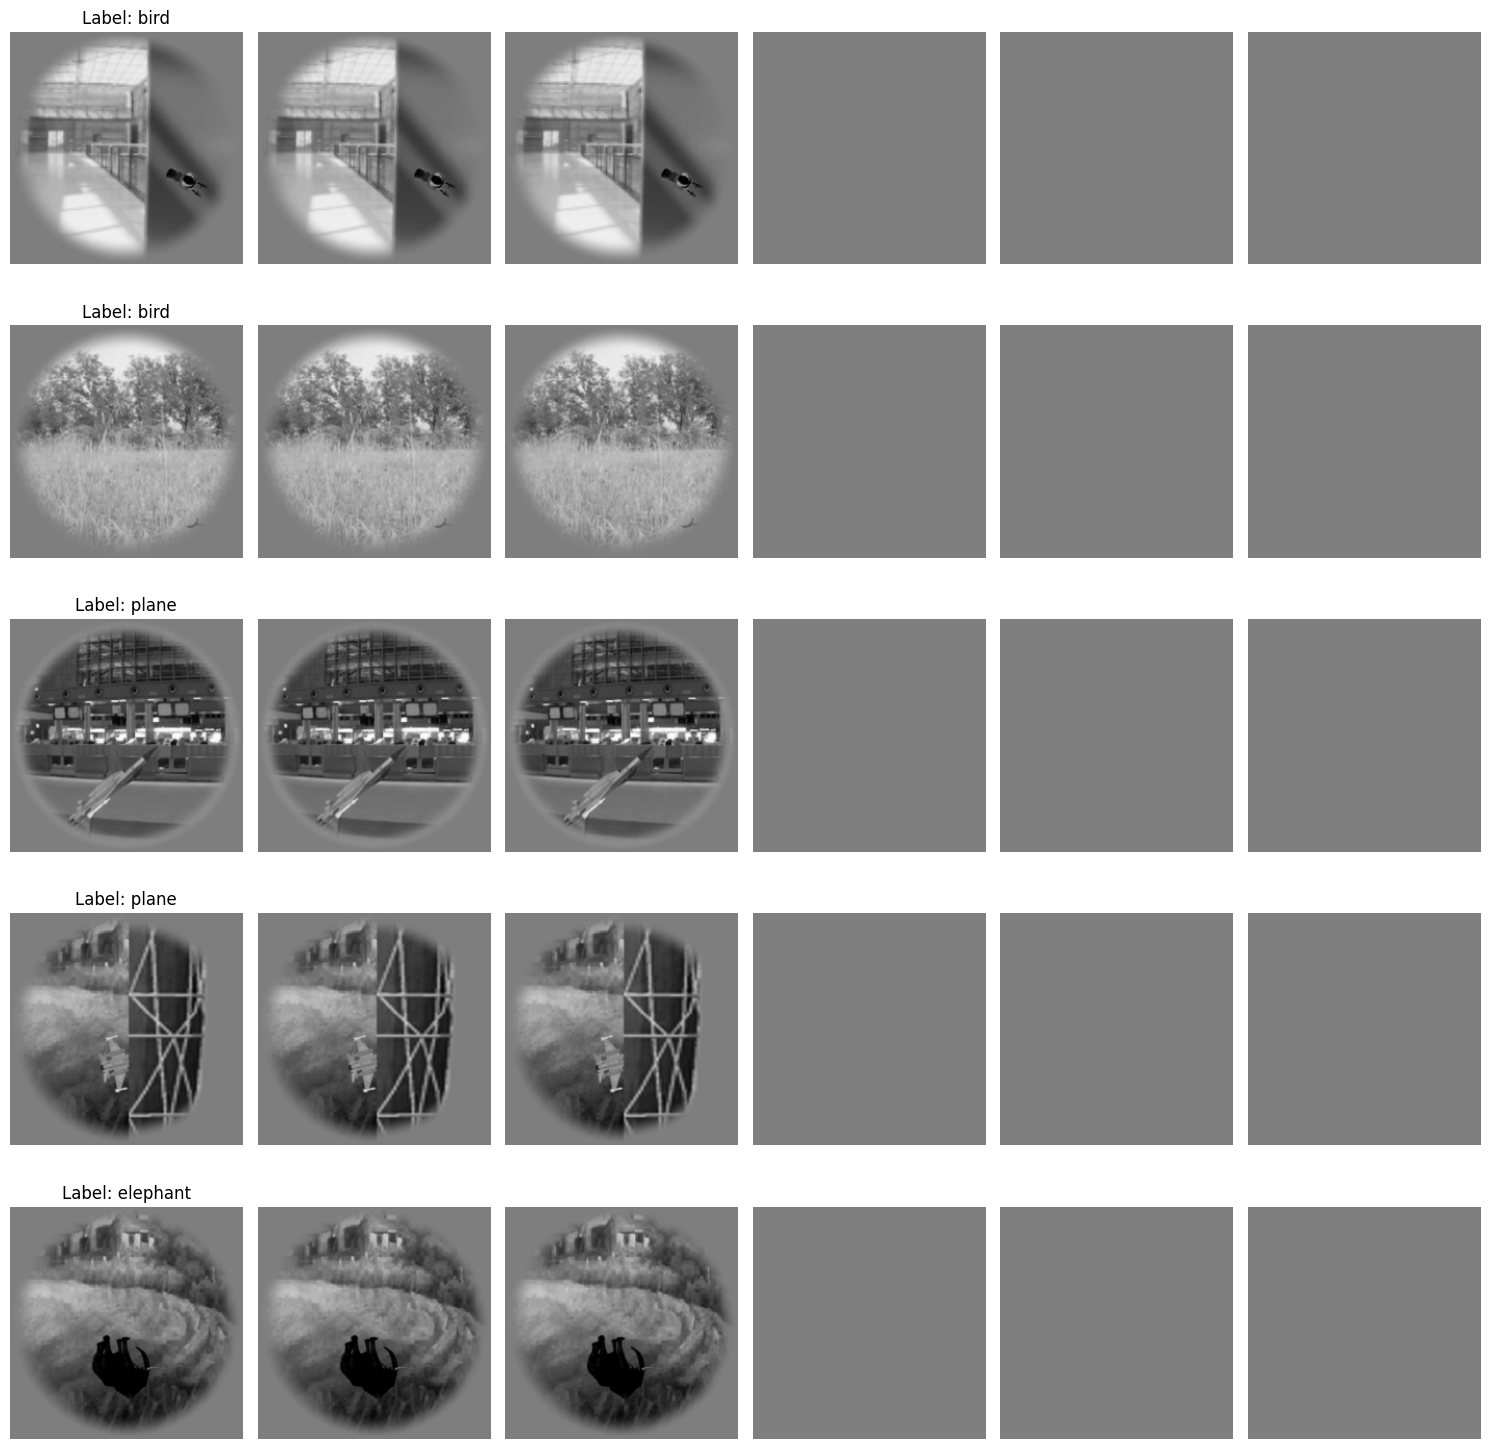

Evaluating the whole system for 100ms delay
Extracted features shape: (200, 512)


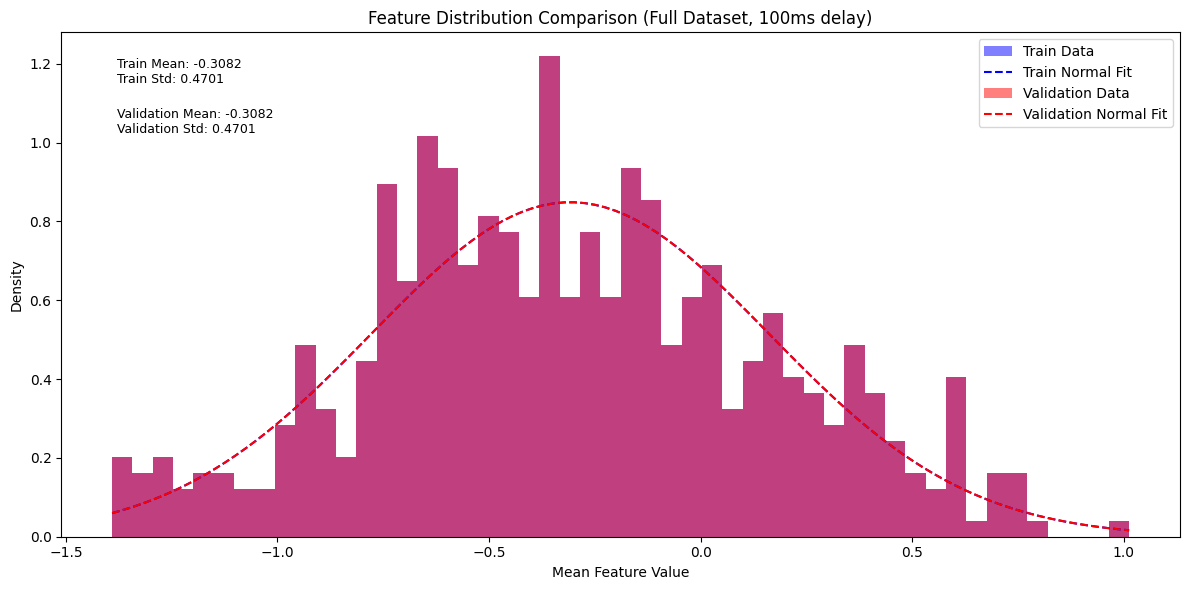

Results saved to 'hvm200_resnetlstm_logistic_evaluation_full_dataset_100ms.csv'
Full Dataset Accuracy: 55.00%

Statistics:
count    2.000000e+02
mean     4.170742e+01
std      3.275434e+01
min      7.499924e-12
25%      7.227721e+00
50%      4.084448e+01
75%      6.935947e+01
max      9.999124e+01
Name: i1, dtype: float64

Top 5 highest i1 values:
     image_index true_label predicted_label         i1
187          187      zebra           zebra  99.991244
188          188      zebra           zebra  99.986292
180          180      zebra           zebra  99.981983
183          183      zebra           zebra  99.977504
191          191      zebra           zebra  98.499865

Bottom 5 lowest i1 values:
     image_index true_label predicted_label            i1
61            61        car             dog  7.499924e-12
55            55     person            bird  5.027525e-05
31            31   elephant            bear  1.439529e-04
84            84        dog            bear  2.226919e-03
15

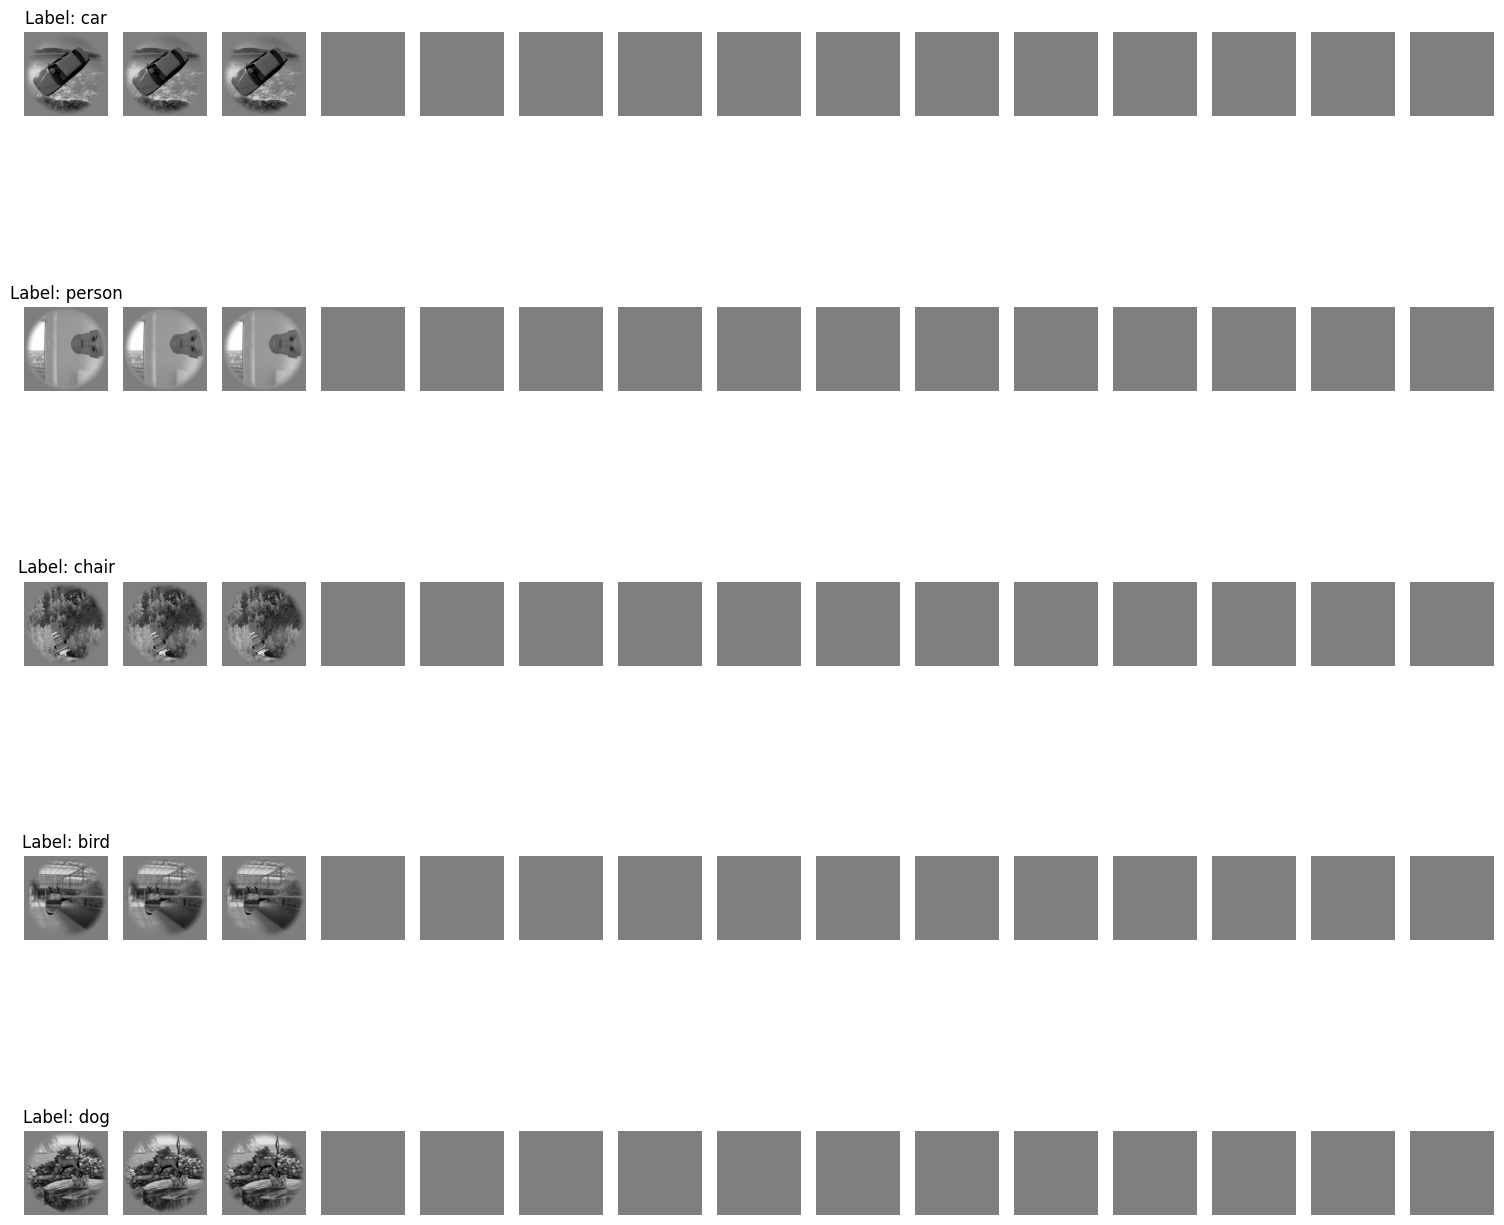

Evaluating the whole system for 400ms delay
Extracted features shape: (200, 512)


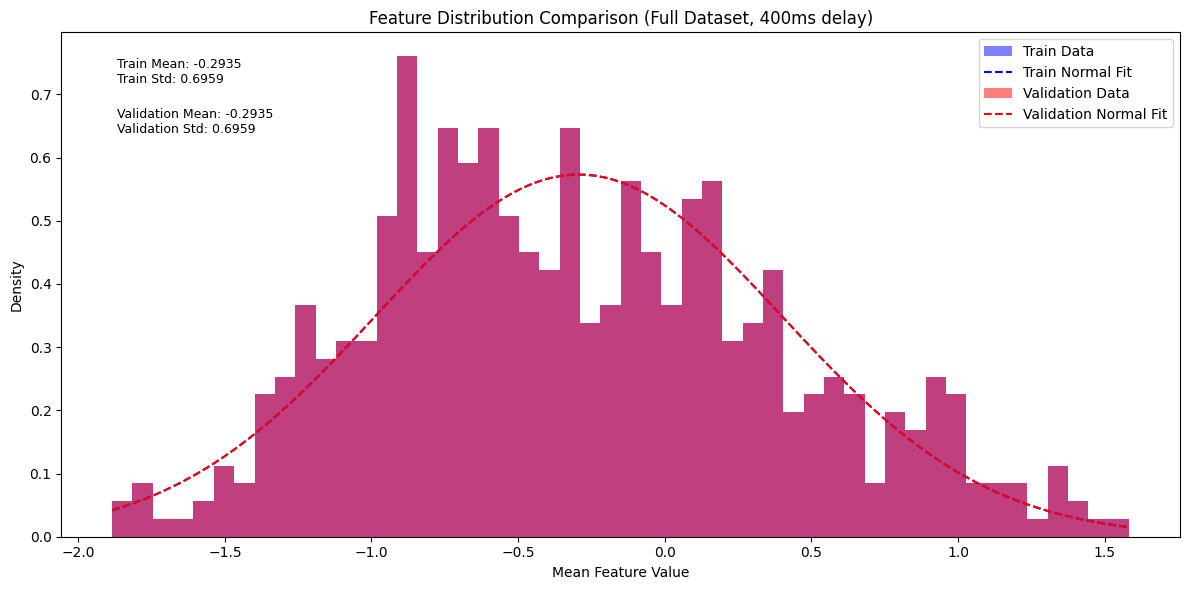

Results saved to 'hvm200_resnetlstm_logistic_evaluation_full_dataset_400ms.csv'
Full Dataset Accuracy: 33.50%

Statistics:
count    2.000000e+02
mean     2.576825e+01
std      2.947164e+01
min      2.493172e-11
25%      3.182578e+00
50%      1.318324e+01
75%      3.652630e+01
max      9.998417e+01
Name: i1, dtype: float64

Top 5 highest i1 values:
     image_index true_label predicted_label         i1
187          187      zebra           zebra  99.984171
180          180      zebra           zebra  99.981094
183          183      zebra           zebra  99.975862
188          188      zebra           zebra  99.972039
119          119      apple           apple  93.303590

Bottom 5 lowest i1 values:
     image_index true_label predicted_label            i1
61            61        car            bear  2.493172e-11
31            31   elephant            bear  1.719431e-03
39            39   elephant           zebra  3.656657e-02
176          176       bird            bear  4.338914e-02
65

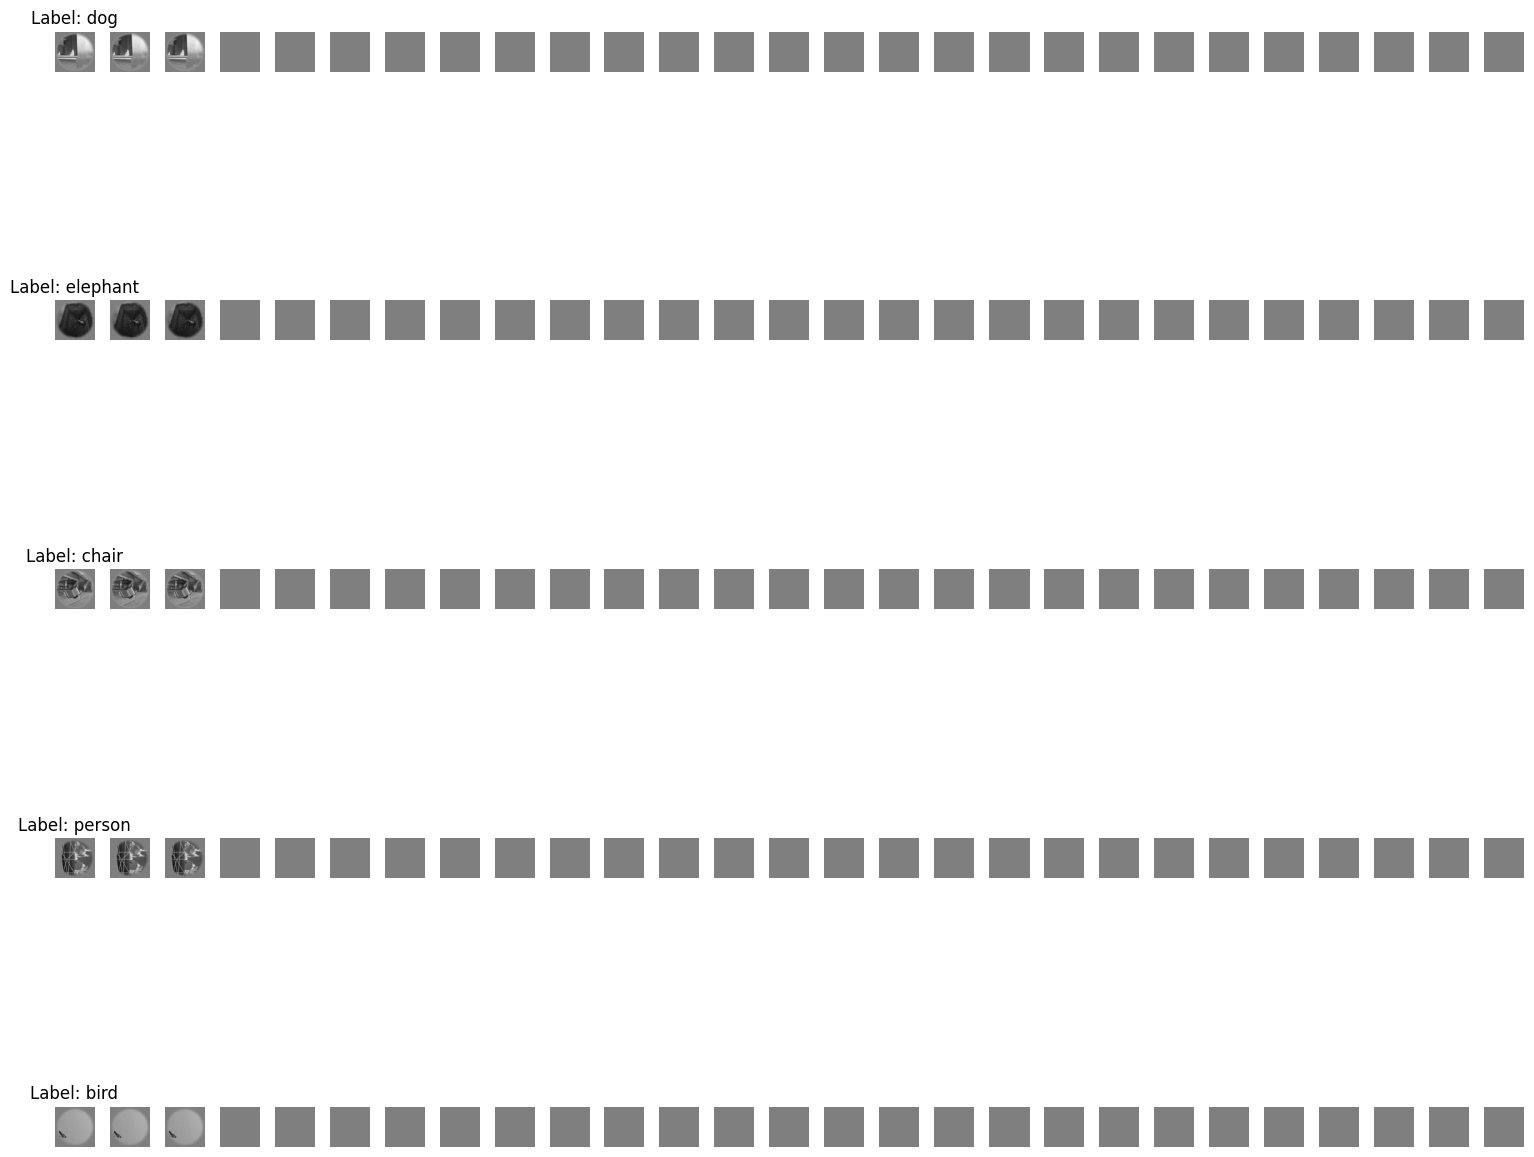

Evaluating the whole system for 800ms delay
Extracted features shape: (200, 512)


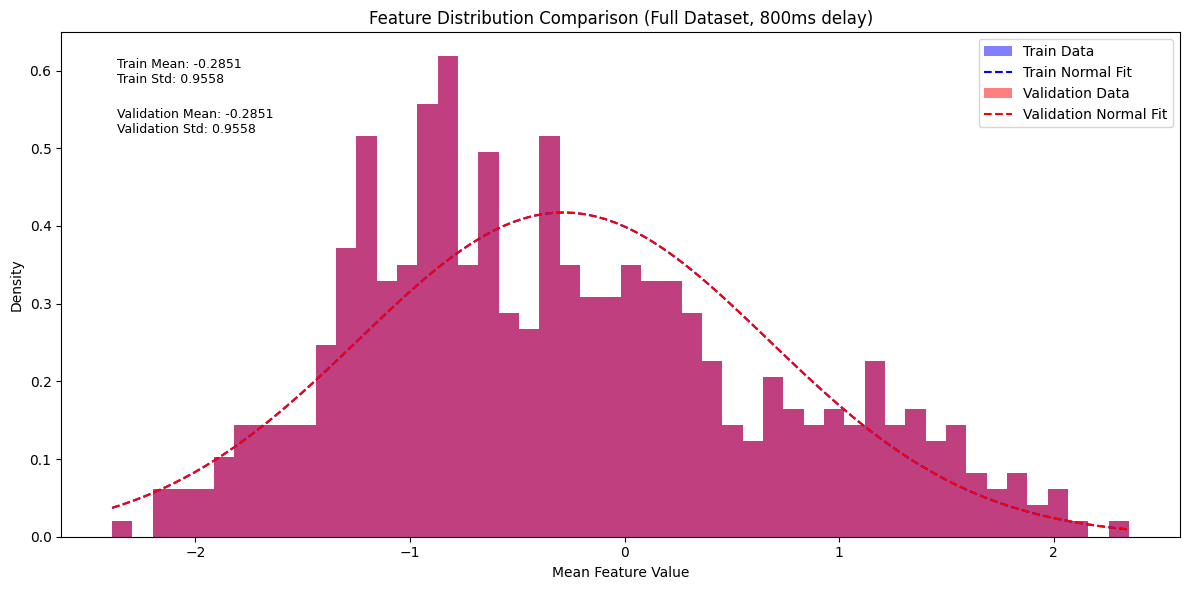

Results saved to 'hvm200_resnetlstm_logistic_evaluation_full_dataset_800ms.csv'
Full Dataset Accuracy: 21.50%

Statistics:
count    200.000000
mean      18.832889
std       27.147936
min        0.000297
25%        0.975573
50%        7.677799
75%       28.177974
max       99.970436
Name: i1, dtype: float64

Top 5 highest i1 values:
     image_index true_label predicted_label         i1
180          180      zebra           zebra  99.970436
187          187      zebra           zebra  99.969990
183          183      zebra           zebra  99.961637
188          188      zebra           zebra  99.952940
104          104      apple           apple  91.947118

Bottom 5 lowest i1 values:
     image_index true_label predicted_label        i1
61            61        car            bear  0.000297
39            39   elephant           zebra  0.006764
156          156      plane           apple  0.024242
148          148      plane           apple  0.114998
128          128      chair           

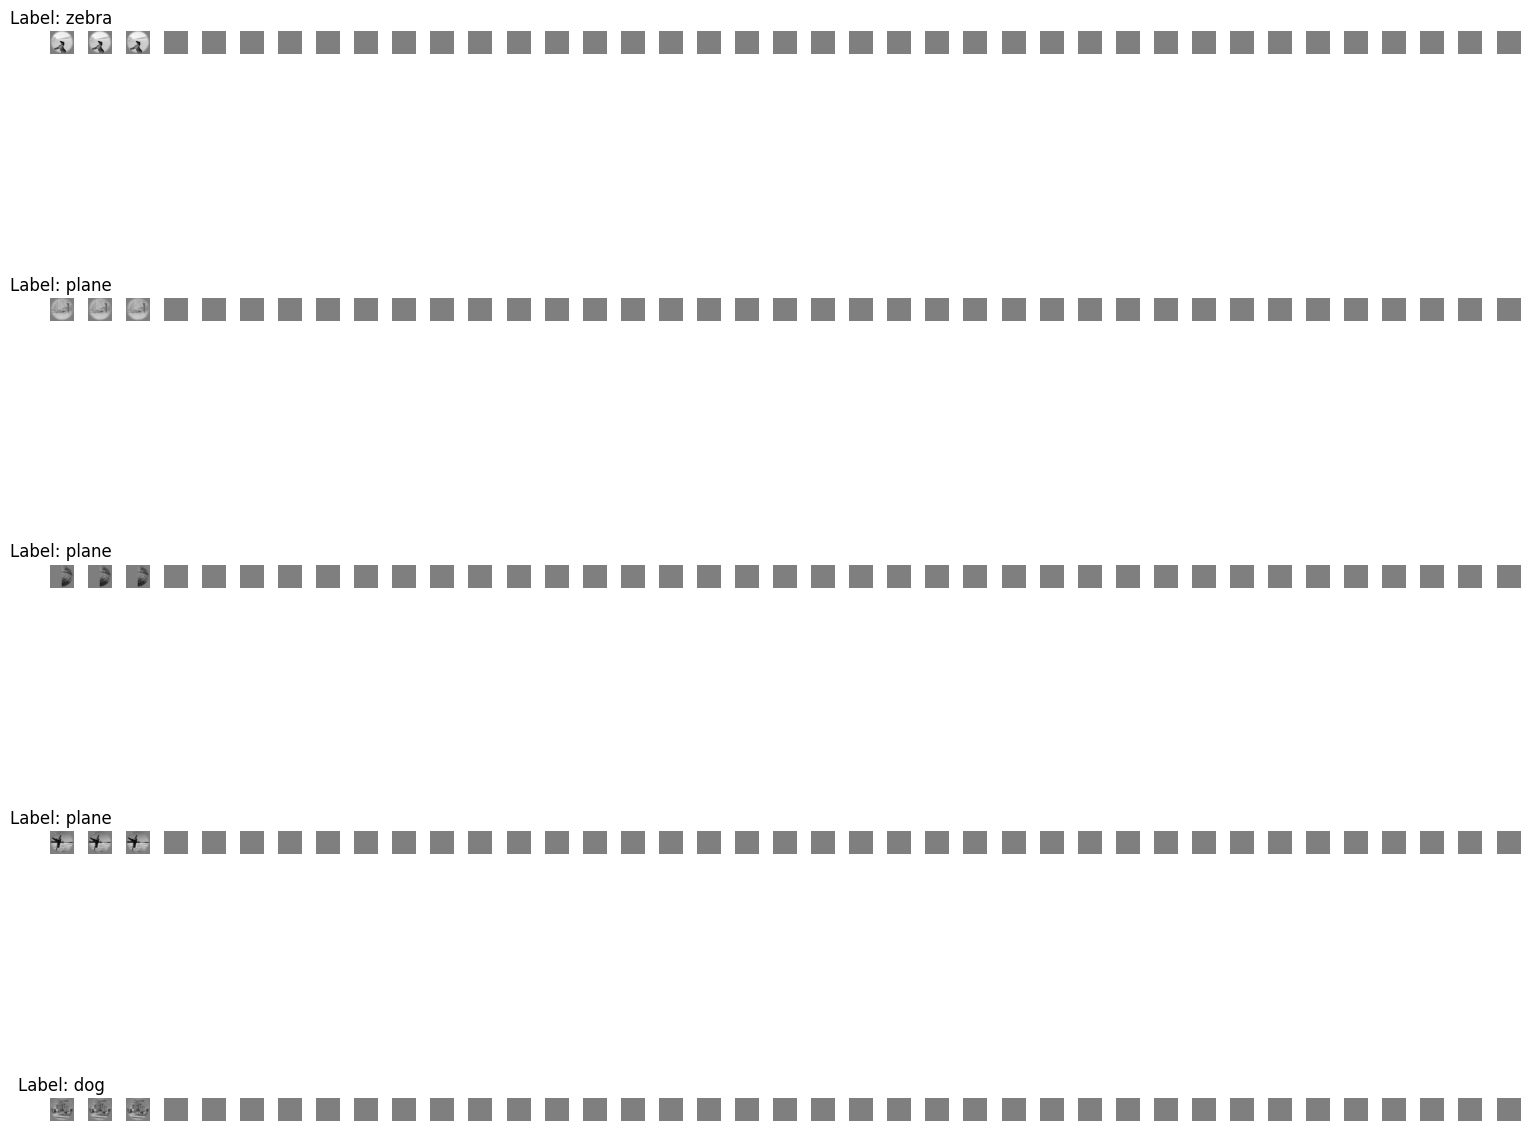

Evaluating the whole system for 1200ms delay
Extracted features shape: (200, 512)


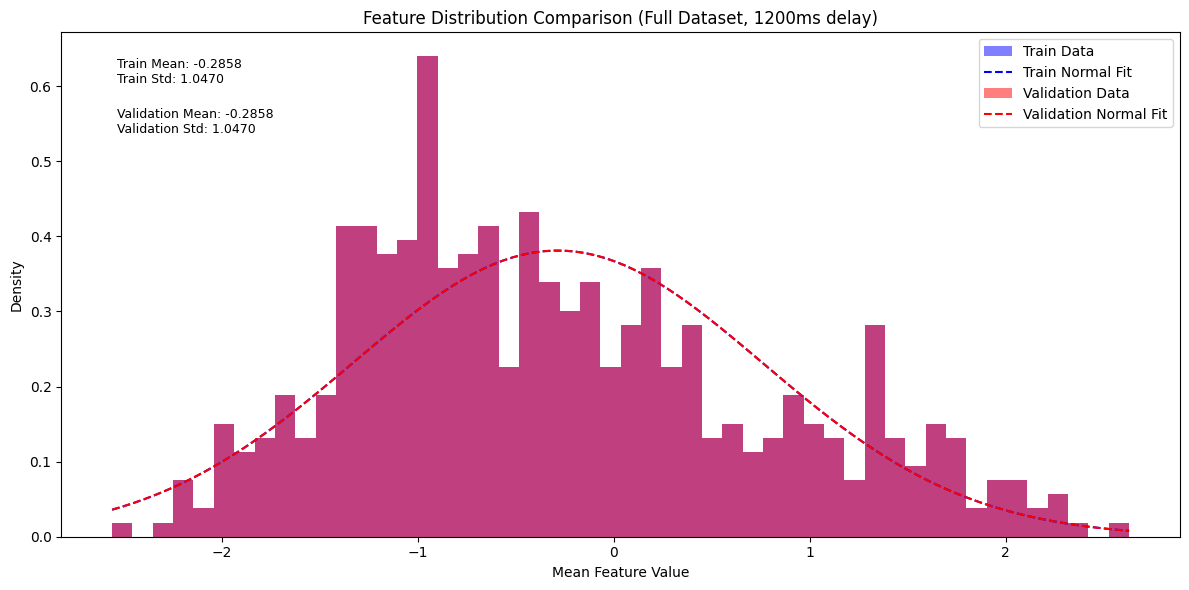

Results saved to 'hvm200_resnetlstm_logistic_evaluation_full_dataset_1200ms.csv'
Full Dataset Accuracy: 20.00%

Statistics:
count    200.000000
mean      18.009286
std       26.929972
min        0.006069
25%        0.636864
50%        5.681452
75%       30.041837
max       99.959721
Name: i1, dtype: float64

Top 5 highest i1 values:
     image_index true_label predicted_label         i1
180          180      zebra           zebra  99.959721
187          187      zebra           zebra  99.957797
183          183      zebra           zebra  99.953022
188          188      zebra           zebra  99.941383
104          104      apple           apple  91.082692

Bottom 5 lowest i1 values:
     image_index true_label predicted_label        i1
39            39   elephant           zebra  0.006069
156          156      plane           apple  0.011297
148          148      plane           apple  0.031245
128          128      chair            bird  0.103248
127          127      chair          

In [22]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Subset
from torchvision import transforms
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import joblib

def create_transform():
    return transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Grayscale(3),
        transforms.Normalize(mean=[0, 0, 0], std=[1, 1, 1]),
    ])

def load_dataset(meta_file, img_dir, num_timesteps, transform):
    return Coco1600SequenceDataset(
        meta_file=meta_file,
        img_dir=img_dir,
        num_timesteps=num_timesteps,
        transform=transform
    )


def load_sth_dataset(img_dir, num_timesteps, transform):

    return HVM200SequenceDataset(img_dir, num_timesteps=num_timesteps, transform=transform) 

def load_model(model_path, num_classes, device):
    model = ResNetLSTM(num_classes)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model = model.to(device)
    model.eval()
    return create_feature_extractor(model, return_nodes={"combine_features.0": "IT"})

def extract_features(model, loader, device):
    features = []
    labels = []
    model.eval()
    with torch.no_grad():
        for images, batch_labels in loader:
            images = images.to(device)
            output = model(images)
            features.append(output['IT'].cpu().numpy())
            labels.append(batch_labels.numpy())
    return np.vstack(features), np.concatenate(labels)

def plot_feature_distributions(X_train, X_val, title_suffix=""):
    plt.figure(figsize=(12, 6))
    
    for X, label, color in [(X_train, 'Train', 'blue'), (X_val, 'Validation', 'red')]:
        mean = np.mean(X, axis=0)
        std = np.std(X, axis=0)
        
        plt.hist(mean, bins=50, density=True, alpha=0.5, color=color, label=f'{label} Data')
        
        mu, sigma = stats.norm.fit(mean)
        x = np.linspace(min(mean), max(mean), 100)
        best_fit_line = stats.norm.pdf(x, mu, sigma)
        plt.plot(x, best_fit_line, color=color, linestyle='--', label=f'{label} Normal Fit')
        
        plt.annotate(f'{label} Mean: {np.mean(mean):.4f}\n{label} Std: {np.std(mean):.4f}', 
                     xy=(0.05, 0.95 - 0.1 * (['Train', 'Validation'].index(label))), 
                     xycoords='axes fraction', 
                     fontsize=9, 
                     ha='left', 
                     va='top')
    
    plt.title(f'Feature Distribution Comparison {title_suffix}')
    plt.xlabel('Mean Feature Value')
    plt.ylabel('Density')
    plt.legend()
    plt.tight_layout()
    plt.show()

def evaluate_model(clf, X, y, idx_to_label):
    y_pred = clf.predict(X)
    y_prob = clf.predict_proba(X)
    accuracy = accuracy_score(y, y_pred)
    
    results = []
    for i in range(len(y)):
        results.append({
            'image_index': i,
            'true_label_idx': y[i],
            'true_label': idx_to_label[y[i]],
            'predicted_label_idx': y_pred[i],
            'predicted_label': idx_to_label[y_pred[i]],
            'i1': y_prob[i, y[i]] * 100,
            **{f'{idx_to_label[j]}_prob': y_prob[i, j] * 100 for j in range(len(idx_to_label))}
        })
    
    return results, accuracy

def process_results(results, accuracy, frame_delay):
    df = pd.DataFrame(results)
    df.to_csv(f'sth200_resnetlstm_logistic_evaluation_full_dataset_{frame_delay}.csv', index=False)
    
    print(f"Results saved to 'hvm200_resnetlstm_logistic_evaluation_full_dataset_{frame_delay}.csv'")
    print(f"Full Dataset Accuracy: {accuracy*100:.2f}%")
    print("\nStatistics:")
    print(df['i1'].describe())
    print("\nTop 5 highest i1 values:")
    print(df.nlargest(5, 'i1')[['image_index', 'true_label', 'predicted_label', 'i1']])
    print("\nBottom 5 lowest i1 values:")
    print(df.nsmallest(5, 'i1')[['image_index', 'true_label', 'predicted_label', 'i1']])

def main():
    # Configuration
    image_path = "data/hvm200/"
    delay_frames = {"100ms": 4, "400ms": 13, "800ms": 25, "1200ms": 37}
    frame_delays = {value: key for key, value in delay_frames.items()}
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Iterate over different delay amounts
    for num_timesteps, delay_name in delay_frames.items():
        print(f"\nEvaluating model with {num_timesteps} delay")
        
        # Load dataset
        transform = create_transform()
        # dataset = load_dataset(
        #     meta_file='data/split_dataset/test_coco1600/coco200_meta.csv',
        #     img_dir='data/split_dataset/test_coco1600/images_cocogray',
        #     num_timesteps=delay_frames[num_timesteps],
        #     transform=transform
        # )
        dataset = load_sth_dataset(image_path, num_timesteps=delay_frames[num_timesteps], transform=transform)

        plot_sequence_samples(dataset)
        num_classes = len(dataset.label_to_idx)
        idx_to_label = {v: k for k, v in dataset.label_to_idx.items()}

        # Load model
        model = load_model(f"version_3_use_resnet_pytorch/resnetPytorch_lstm_finetuned_100ms_delay_coco1400_100ms_object_best.pth", num_classes, device)

        # Load classifier
        clf = joblib.load('best_logistic_regression_model.joblib')

        # Feature extraction and evaluation
        print(f"Evaluating the whole system for {num_timesteps} delay")
        full_loader = DataLoader(dataset, batch_size=32, shuffle=False)
        X, y = extract_features(model, full_loader, device)
        print(f"Extracted features shape: {X.shape}")
        
        # Plot feature distribution
        plot_feature_distributions(X, X, title_suffix=f"(Full Dataset, {num_timesteps} delay)")
        
        # Scale features if necessary
        X_scaled = clf.named_steps['scaler'].transform(X) if hasattr(clf, 'named_steps') and 'scaler' in clf.named_steps else X

        # Evaluate
        results, accuracy = evaluate_model(clf, X_scaled, y, idx_to_label)
        process_results(results, accuracy, num_timesteps)

if __name__ == "__main__":
    main()

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def load_and_preprocess_data(file_path):
    df = pd.read_csv(file_path)
    df['B.I1'] = df['i1']
    df['B.I1n'] = df.groupby('true_label')['B.I1'].transform(lambda x: (x - x.mean()) / x.std())
    df['image_name'] = 'image_' + df['image_index'].astype(str).str.zfill(4)
    return df

def calculate_mean_per_object(df):
    return df.groupby('true_label')['B.I1'].mean().sort_values(ascending=False)

def create_heatmap_dataframes(df, label_order):
    df_sorted = df.sort_values(['true_label'], key=lambda x: pd.Categorical(x, categories=label_order, ordered=True))
    df_heatmap_bi1 = df_sorted[['true_label', 'B.I1', 'image_name']].copy()
    df_heatmap_bi1n = df_sorted[['true_label', 'B.I1n', 'image_name']].copy()
    return df_heatmap_bi1, df_heatmap_bi1n

def plot_heatmaps(df_heatmap_bi1, df_heatmap_bi1n, mean_per_object, label_order, delay):
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(3, 12), gridspec_kw={'height_ratios': [0.4, 0.2, 0.4]})

    # B.I1 heatmap
    sns.heatmap(df_heatmap_bi1.set_index('image_name')[['B.I1']], 
                cmap='rainbow', cbar=True, ax=ax1, 
                vmin=df_heatmap_bi1['B.I1'].min(), vmax=df_heatmap_bi1['B.I1'].max())
    ax1.set_xlabel('B.I1')
    ax1.set_ylabel('Images')
    ax1.set_title(f'B.I1 Heatmap ({delay}ms)')

    # Mean per object heatmap
    sns.heatmap(mean_per_object.loc[label_order].to_frame(), cmap='rainbow', cbar=True, ax=ax2, 
                vmin=mean_per_object.min(), vmax=mean_per_object.max())
    ax2.set_xlabel('Mean B.I1')
    ax2.set_ylabel('True Label')
    ax2.set_title(f'Mean B.I1 per Object ({delay}ms)')

    # B.I1n heatmap
    sns.heatmap(df_heatmap_bi1n.set_index('image_name')[['B.I1n']], 
                cmap='rainbow', cbar_kws={'label': 'B.I1n Value'}, ax=ax3, 
                vmin=df_heatmap_bi1n['B.I1n'].min(), vmax=df_heatmap_bi1n['B.I1n'].max())
    ax3.set_xlabel('B.I1n')
    ax3.set_ylabel('Images')
    ax3.set_title(f'B.I1n Heatmap ({delay}ms)')

    plt.tight_layout()
    plt.savefig(f'bi1_bi1n_heatmap_{delay}ms.png', dpi=300, bbox_inches='tight')
    plt.close()
    print(f"Heatmap saved as 'bi1_bi1n_heatmap_{delay}ms.png'")

def save_bi1_data(df, file_name):
    df[['image_name', 'true_label', 'predicted_label', 'B.I1', 'B.I1n']].to_csv(file_name, index=False)
    print(f"B.I1 and B.I1n data saved to {file_name}")

def print_statistics(df):
    print("\nB.I1 Statistics:")
    print(df['B.I1'].describe())
    print("\nB.I1n Statistics:")
    print(df['B.I1n'].describe())
    print("\nTop 5 highest B.I1 values:")
    print(df.nlargest(5, 'B.I1')[['image_name', 'true_label', 'predicted_label', 'B.I1']])
    print("\nBottom 5 lowest B.I1 values:")
    print(df.nsmallest(5, 'B.I1')[['image_name', 'true_label', 'predicted_label', 'B.I1']])

def main():
    coco1600_to_hvm200 = {
        "bear": "bear",
        "ELEPHANT_M": "elephant",
        "face0001": "person",
        "alfa155": "car",
        "breed_pug": "dog",
        "Apple_Fruit_obj": "apple",
        "_001": "chair",
        "f16": "plane",
        "lo_poly_animal_CHICKDEE": "bird",
        "zebra": "zebra"
    }
    # coco200
    coco200_label_order = list(coco1600_to_hvm200.keys())

    # hvm200
    hvm200_label_order = list(coco1600_to_hvm200.values())

    for delay in [100, 400, 800, 1200]:
        print(f"Delay: {delay}ms")
        file_path = f'sth200_resnetlstm_logistic_evaluation_full_dataset_{delay}ms.csv'
        df = load_and_preprocess_data(file_path)
        mean_per_object = calculate_mean_per_object(df)
        df_heatmap_bi1, df_heatmap_bi1n = create_heatmap_dataframes(df, hvm200_label_order)
        
        plot_heatmaps(df_heatmap_bi1, df_heatmap_bi1n, mean_per_object, hvm200_label_order, delay)
        save_bi1_data(df, f'sth200_bi1_bi1n_data_{delay}ms.csv')
        print_statistics(df)

if __name__ == "__main__":
    main()

Delay: 100ms
Heatmap saved as 'bi1_bi1n_heatmap_100ms.png'
B.I1 and B.I1n data saved to sth200_bi1_bi1n_data_100ms.csv

B.I1 Statistics:
count    2.000000e+02
mean     4.170742e+01
std      3.275434e+01
min      7.499924e-12
25%      7.227721e+00
50%      4.084448e+01
75%      6.935947e+01
max      9.999124e+01
Name: B.I1, dtype: float64

B.I1n Statistics:
count    2.000000e+02
mean    -3.774758e-17
std      9.771253e-01
min     -2.765893e+00
25%     -8.510529e-01
50%     -9.390886e-03
75%      7.460361e-01
max      2.207536e+00
Name: B.I1n, dtype: float64

Top 5 highest B.I1 values:
     image_name true_label predicted_label       B.I1
187  image_0187      zebra           zebra  99.991244
188  image_0188      zebra           zebra  99.986292
180  image_0180      zebra           zebra  99.981983
183  image_0183      zebra           zebra  99.977504
191  image_0191      zebra           zebra  98.499865

Bottom 5 lowest B.I1 values:
     image_name true_label predicted_label          B.I

Plot saved as delay_consistencies.png


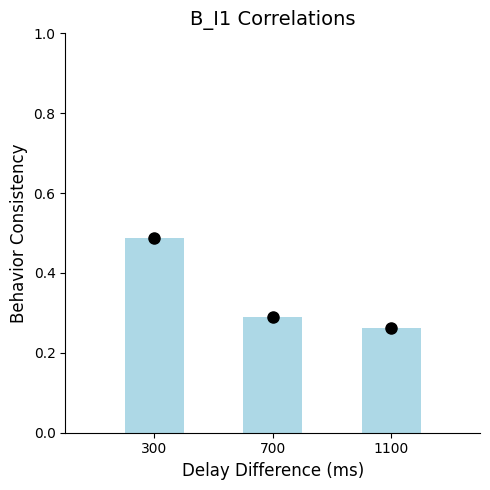

In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

def behavioral_metrics_corr(b1: np.ndarray, b2: np.ndarray, r1, r2):
    if b1.ndim == 2:
        b1 = b1.reshape(-1)
    if b2.ndim == 2:
        b2 = b2.reshape(-1)
    correlation, _ = pearsonr(b1, b2)
    reliability_adjusted_correlation = correlation
    if reliability_adjusted_correlation > 1.0:
        reliability_adjusted_correlation = 1.0
    return reliability_adjusted_correlation

def calculate_delay_consistencies(delay_files):
    delay_data = {}
    for delay, file in delay_files.items():
        df = pd.read_csv(file)
        delay_data[delay] = df['B.I1'].values
    
    base_delay = '100ms'
    consistencies = {}
    delays = [d for d in delay_files.keys() if d != base_delay]
    
    for delay in delays:
        consistency = behavioral_metrics_corr(
            delay_data[base_delay], delay_data[delay], 1, 1
        )
        delay_diff = abs(int(delay.replace('ms','')) - 100)
        consistencies[delay_diff] = consistency
    
    return consistencies

def plot_delay_consistencies(consistencies):
    fig, ax = plt.subplots(figsize=(5, 5))
    
    # Define x positions for bars (300, 700, 1100)
    x_pos = np.array([300, 700, 1100])
    values = [consistencies[d] for d in sorted(consistencies.keys())]
    
    # Plot bars with reduced width to create spacing
    bars = ax.bar(x_pos, values, color='lightblue', width=200, align='center')
    
    # Add black dots on top of bars
    for x, y in zip(x_pos, values):
        ax.plot(x, y, 'ko', markersize=8)
    
    # Customize the plot
    ax.set_xlabel('Delay Difference (ms)', fontsize=12)
    ax.set_ylabel('Behavior Consistency', fontsize=12)
    ax.set_title('B_I1 Correlations', fontsize=14)
    
    # Set axis limits
    ax.set_ylim(0, 1.0)
    ax.set_xlim(0, 1400)  # Adjust x-axis limits to accommodate bars
    
    # Set x-ticks at bar centers
    ax.set_xticks(x_pos)
    ax.set_xticklabels([str(x) for x in x_pos])
    
    # Remove top and right spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    plt.tight_layout()
    return fig

# Example usage
delay_files = {
    '100ms': 'sth200_bi1_bi1n_data_100ms.csv',
    '400ms': 'sth200_bi1_bi1n_data_400ms.csv',
    '800ms': 'sth200_bi1_bi1n_data_800ms.csv',
    '1200ms': 'sth200_bi1_bi1n_data_1200ms.csv'
}

consistencies = calculate_delay_consistencies(delay_files)
fig = plot_delay_consistencies(consistencies)

# Save the plot
plt.savefig('delay_consistencies.png', dpi=500, bbox_inches="tight", format="png")
print("Plot saved as delay_consistencies.png")